In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

2024-11-26 17:28:50.181031: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-26 17:28:52.287632: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2024-11-26 17:28:52.287802: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2024-11-26 17:28:52.310882: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2024-11-26 17:28:53.103148: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 2 compatible adapters.


In [2]:
import glob
import os
import PIL
import time

from IPython import display

In [3]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [4]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [5]:
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

2024-11-26 17:28:54.101822: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-26 17:28:54.102931: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (NVIDIA T400 4GB)
2024-11-26 17:28:54.388346: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 1 (Intel(R) Iris(R) Xe Graphics)
2024-11-26 17:28:54.486428: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-26 17:28:54.486668: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Yo

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
    )

In [7]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Now, we transfer the weights of discriminator except the last layer to a new model, add a dense layer with 128 units, and add another dense layer with 10 units and softmax activation.

In [8]:
disc = checkpoint.discriminator

new_model = Sequential()
for i in range(len(disc.layers) - 1):
    new_model.add(disc.layers[i])

# freeze the layers 
for layer in new_model.layers:
    layer.trainable = False    

new_model.add(Dense(128))
new_model.add(Dense(10, activation='softmax'))
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [9]:
# view the initialized weights and bias of the second last dense layer; weights are uniformly randomly generated 
# and biases are all zeroes by default
new_model.layers[-2].weights

[<tf.Variable 'dense_2/kernel:0' shape=(6272, 128) dtype=float32, numpy=
 array([[ 0.02117861, -0.01262695, -0.02099196, ...,  0.00461027,
         -0.00266506,  0.0293588 ],
        [-0.00628337, -0.01494586,  0.01365256, ...,  0.01601861,
         -0.01066783,  0.00755522],
        [-0.00775048,  0.02555346, -0.01435698, ...,  0.00019605,
          0.00467337, -0.00511559],
        ...,
        [-0.00726299,  0.01035534, -0.00461954, ...,  0.00734683,
         -0.02147423, -0.01930649],
        [ 0.00603352, -0.00882063, -0.00282877, ...,  0.02683636,
         -0.00277031,  0.00366258],
        [ 0.02588844,  0.02573447,  0.01573719, ...,  0.0263838 ,
         -0.012235  , -0.03000783]], dtype=float32)>,
 <tf.Variable 'dense_2/bias:0' shape=(128,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [10]:
(train_img, train_lb), (test_img, test_lb) = tf.keras.datasets.mnist.load_data()

print(train_img.shape, train_lb.shape, test_img.shape, test_lb.shape, '\n')

# set random seed
np.random.seed(42)
trainsize = 10000  # number of training images we use, selected randomly
randtrain = np.random.choice(train_img.shape[0], trainsize, replace=False)
X_train, y_train = train_img[randtrain], train_lb[randtrain]

np.random.seed(10)
testsize = 10000  # number of testing images we use, selected randomly
randtest = np.random.choice(test_img.shape[0], testsize, replace=False)
X_test, y_test = test_img[randtest], test_lb[randtest]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,) 

(10000, 28, 28) (10000,) (10000, 28, 28) (10000,)


In [11]:
train_images = X_train.reshape((trainsize, 28, 28, 1))
train_images = (train_images.astype('float32') - 127.5) / 127.5

test_images = X_test.reshape((testsize, 28, 28, 1))
test_images = (test_images.astype('float32') - 127.5) / 127.5

train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

new_model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history1 = new_model.fit(train_images, train_labels, batch_size=100, epochs=7,
                        validation_data=(test_images, test_labels))


2024-11-26 17:28:58.614816: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 31360000 exceeds 10% of free system memory.
2024-11-26 17:28:58.848190: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 31360000 exceeds 10% of free system memory.


Epoch 1/7


2024-11-26 17:28:59.655202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 99/100 [============================>.] - ETA: 0s - loss: 1.4013 - accuracy: 0.6541

2024-11-26 17:29:08.992047: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 31360000 exceeds 10% of free system memory.
2024-11-26 17:29:09.044264: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 31360000 exceeds 10% of free system memory.
2024-11-26 17:29:09.267991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 11s 46ms/step - loss: 1.3969 - accuracy: 0.6553 - val_loss: 0.8671 - val_accuracy: 0.8356
Epoch 2/7
100/100 [==============================] - 4s 43ms/step - loss: 0.7647 - accuracy: 0.8298 - val_loss: 0.6147 - val_accuracy: 0.8667
Epoch 3/7
100/100 [==============================] - 4s 43ms/step - loss: 0.6020 - accuracy: 0.8546 - val_loss: 0.5119 - val_accuracy: 0.8814
Epoch 4/7
100/100 [==============================] - 4s 43ms/step - loss: 0.5220 - accuracy: 0.8702 - val_loss: 0.4544 - val_accuracy: 0.8885
Epoch 5/7
100/100 [==============================] - 4s 45ms/step - loss: 0.4709 - accuracy: 0.8776 - val_loss: 0.4165 - val_accuracy: 0.8952
Epoch 6/7
100/100 [==============================] - 6s 63ms/step - loss: 0.4381 - accuracy: 0.8850 - val_loss: 0.3902 - val_accuracy: 0.8990
Epoch 7/7
100/100 [==============================] - 5s 46ms/step - loss: 0.4116 - accuracy: 0.8875 - val_loss: 0.3700 - val_accuracy: 0.9036


In [12]:
# unfreeze all layers 
for layer in new_model.layers:
    layer.trainable = True

# optimizer=new_model.optimizer
# optimizer.learning_rate=0.005
    
new_model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history2 = new_model.fit(train_images, train_labels, batch_size=100, epochs=8,
                        validation_data=(test_images, test_labels)) 


2024-11-26 17:29:38.883683: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 31360000 exceeds 10% of free system memory.


Epoch 1/8


2024-11-26 17:29:39.664002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 99/100 [============================>.] - ETA: 0s - loss: 0.3580 - accuracy: 0.8944

2024-11-26 17:29:54.166592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 16s 60ms/step - loss: 0.3581 - accuracy: 0.8949 - val_loss: 0.3065 - val_accuracy: 0.9117
Epoch 2/8
100/100 [==============================] - 6s 56ms/step - loss: 0.3176 - accuracy: 0.9063 - val_loss: 0.2844 - val_accuracy: 0.9179
Epoch 3/8
100/100 [==============================] - 7s 74ms/step - loss: 0.2971 - accuracy: 0.9128 - val_loss: 0.2682 - val_accuracy: 0.9208
Epoch 4/8
100/100 [==============================] - 6s 57ms/step - loss: 0.2786 - accuracy: 0.9204 - val_loss: 0.2547 - val_accuracy: 0.9266
Epoch 5/8
100/100 [==============================] - 6s 57ms/step - loss: 0.2649 - accuracy: 0.9211 - val_loss: 0.2427 - val_accuracy: 0.9315
Epoch 6/8
100/100 [==============================] - 6s 57ms/step - loss: 0.2469 - accuracy: 0.9279 - val_loss: 0.2326 - val_accuracy: 0.9351
Epoch 7/8
100/100 [==============================] - 6s 58ms/step - loss: 0.2331 - accuracy: 0.9330 - val_loss: 0.2244 - val_accuracy: 0.9372
Epoch 8/8
100/1

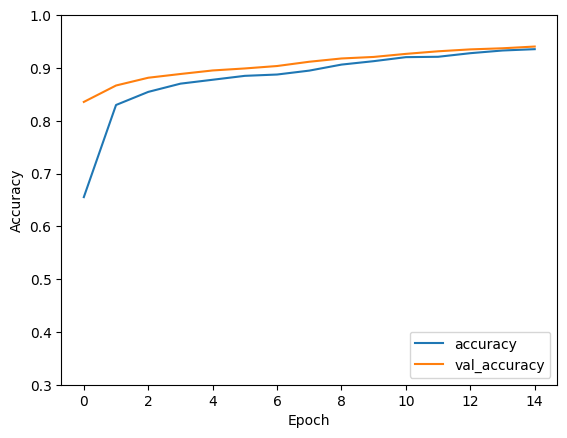

In [13]:
accuracy = history1.history['accuracy'] + history2.history['accuracy']
val_accuracy = history1.history['val_accuracy'] + history2.history['val_accuracy']

plt.figure()
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')
plt.show()

We can see that, using the tuned discriminator model, both training accuracy and testing are approximately 0.94 after 15 epochs.

actual label: 8


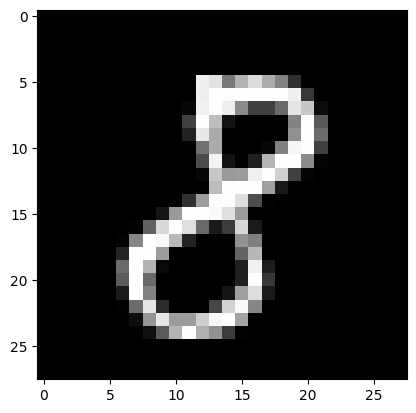

2024-11-26 17:30:38.084410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step
[[5.1546661e-04 4.6938568e-04 1.5255328e-02 8.2626589e-02 2.5355814e-05
  2.0551470e-03 1.6611126e-05 1.6826189e-05 8.9721668e-01 1.8026714e-03]]
prediction: 8


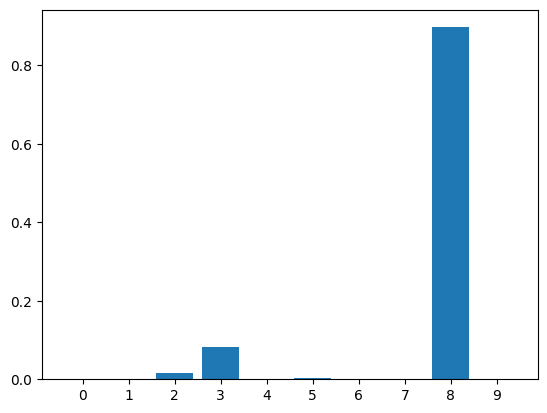

In [14]:
# demonstration: predict the ith test digit
i = np.random.randint(0, trainsize)

# show the actual ith digit
print('actual label:', np.argmax(test_labels[i]))
plt.figure()
plt.imshow(test_images[i,:,:,0], cmap='gray')
plt.show()

# predict
prediction = new_model.predict(test_images[i].reshape(1,28,28,1))

# get probability distribution and classification of the test digit
print(prediction)
print('prediction:', np.argmax(prediction))

# draw the barplot
plt.figure()
plt.bar(np.arange(0,10).astype('str'), prediction[0,:])
plt.show()

**Get Confusion Matrix**

In [15]:
pred_labels = new_model.predict(test_images).argmax(axis=1)
true_labels = test_labels.argmax(axis=1)

313/313 [==============================] - 6s 17ms/step


2024-11-26 17:30:48.017626: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-26 17:30:48.017694: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-26 17:30:48.017735: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 17714 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-11-26 17:30:48.017757: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:1 with 14553 MB memory) -> physical PluggableDevice (device: 1, name: 

In [16]:
confusion_mat = tf.math.confusion_matrix(labels=true_labels, predictions=pred_labels).numpy()
confusion_mat

2024-11-26 17:30:48.895712: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-26 17:30:48.895785: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-26 17:30:48.895835: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 17714 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-11-26 17:30:48.895864: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:1 with 14553 MB memory) -> physical PluggableDevice (device: 1, name: 

array([[ 964,    0,    1,    2,    0,    2,    8,    1,    2,    0],
       [   0, 1122,    2,    2,    0,    0,    4,    1,    4,    0],
       [  10,    2,  940,   18,   11,    0,   11,   11,   23,    6],
       [   2,    1,   14,  944,    1,   11,    3,   12,   14,    8],
       [   1,    3,    2,    0,  938,    0,   13,    1,    4,   20],
       [   7,    3,    0,   16,    2,  821,   14,    4,   18,    7],
       [  10,    4,    1,    1,   14,    6,  919,    0,    3,    0],
       [   2,    8,   20,    6,    7,    1,    0,  948,    2,   34],
       [   8,    9,    7,   12,    7,    8,    9,   11,  888,   15],
       [   9,    6,    2,    8,   28,    6,    1,   16,   12,  921]],
      dtype=int32)

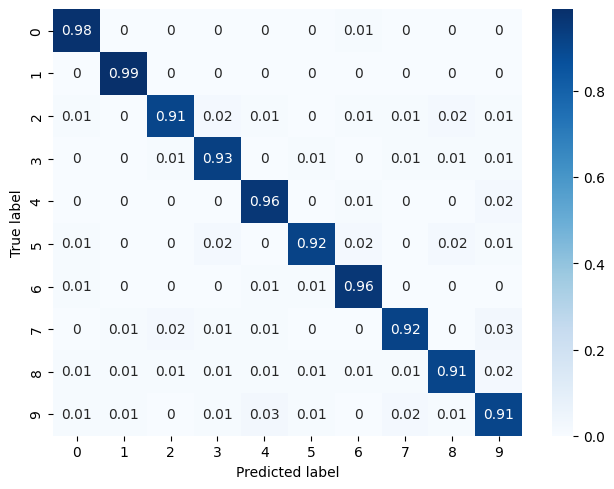

In [17]:
import pandas as pd
import seaborn as sns

confusion_mat_norm = np.around(confusion_mat.astype('float') / np.atleast_2d(confusion_mat.sum(axis=1)).T, decimals=2)

classes = np.arange(0,10).astype('str')
confusion_mat_df = pd.DataFrame(confusion_mat_norm,
                                index = classes, 
                                columns = classes)

figure = plt.figure()
sns.heatmap(confusion_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

**Generate new digits and perform classification on them using our model**

2024-11-26 17:30:50.712809: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-26 17:30:50.712900: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-26 17:30:50.712959: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 17714 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-11-26 17:30:50.712990: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:1 with 14553 MB memory) -> physical PluggableDevice (device: 1, name: 

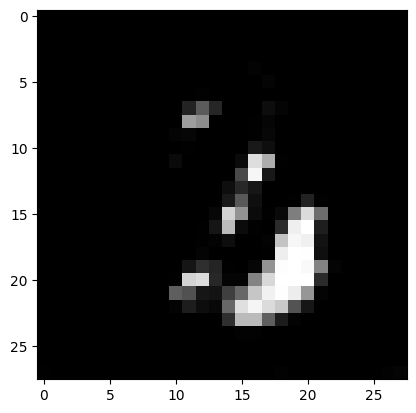

In [18]:
noi = tf.random.normal([1, 100])
sample = checkpoint.generator(noi, training=False)
fig = plt.figure()
plt.imshow(sample[0, :, :, 0], cmap='gray')

1/1 [==============================] - 0s 71ms/step
[[0.00606514 0.07792143 0.05812542 0.29838458 0.01418889 0.3295483
  0.18880163 0.01428105 0.00704792 0.00563565]]
prediction: 5


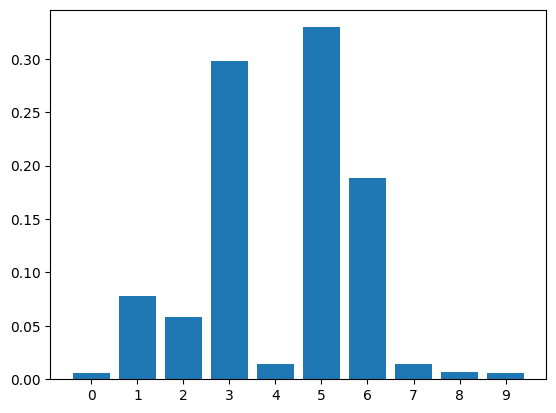

In [19]:
new_sample = sample[0, :, :, 0].numpy().reshape(1,28,28,1)
new_prediction = new_model.predict(new_sample)

# get probability distribution and classification of the test digit
print(new_prediction)
print('prediction:', np.argmax(new_prediction))

# draw the barplot
plt.figure()
plt.bar(np.arange(0,10).astype('str'), new_prediction[0,:])
plt.show()

In [20]:
# we can save the numpy array of appropriately generated digits as .npy file,
# which could be used for further training
np.save('generated_numpy.npy', sample[0, :, :, 0].numpy())

In [21]:
# upload the saved numpy array
arr = np.load('generated_numpy.npy')
arr

array([[-0.99524355, -0.9985982 , -0.99962884, -0.9997818 , -0.99997705,
        -0.9999707 , -0.99999434, -0.99998415, -0.99998677, -0.99996835,
        -0.99999356, -0.99999505, -0.9999975 , -0.99999374, -0.999998  ,
        -0.999995  , -0.999986  , -0.99990964, -0.99996036, -0.99992   ,
        -0.99993974, -0.99987066, -0.9999763 , -0.9999531 , -0.9999753 ,
        -0.99984336, -0.99996257, -0.998922  ],
       [-0.99395716, -0.999429  , -0.999685  , -0.9999886 , -0.99999464,
        -0.9999972 , -0.99999833, -0.99999934, -0.9999989 , -0.99999917,
        -0.9999994 , -0.99999994, -0.9999998 , -0.99999833, -0.99999815,
        -0.9999987 , -0.99998945, -0.9999261 , -0.9999203 , -0.9999871 ,
        -0.9999645 , -0.99997014, -0.99998814, -0.999998  , -0.9999922 ,
        -0.99993676, -0.9999262 , -0.99941796],
       [-0.9996174 , -0.9999776 , -0.99999654, -0.99999994, -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.    